In [28]:
import h5py
import numpy as np
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## Variables

In [29]:
## Oblasti
regions = {
    "1": "Česká",
    "2": "Středomoravská",
    "3": "Východomoravská",
    "4": "Slezkomoravská",
}

## Podoblasti
subregions = {
    "1-1": "Severovýchodočeská",
    "1-2": "Středočeská",
    "1-3": "Jihozápadočeská",
    "1-4": "Českomoravská",
    "2-1": "Jižní",
    "2-2": "Západní",
    "2-3": "Východní",
    "2-4": "Centrální",
    "3-1": "Slovácko ",
    "3-2": "Zlinsko",
    "3-3": "Valašsko",
    "4-1": "Slezskomoravská",
    "4-2": "Slezskopolská",
}

## Auxiliary functions

In [30]:

def load_h5_file(file):
    """Reads h5 file with specific group index and returns loaded data as numpy arrays

    Returns:
        tuple: name, group_id, data
    """
    with h5py.File(file, "r") as hf:
        name = np.array(hf["Name"]).flatten()
        group_id = np.array(hf["GroupID"]).flatten()
        sid = np.array(hf["SubgroupID"]).flatten()
        data = np.array(hf["Data"])

    return name, group_id, sid, data

def confusion_matrix(scores, labs, priors=None):
    """Create confusion matrix, where rows corresponds to true classes and
    columns corresponds to classes recognized from input likelihoods:
    Input:
    scores: N-by-T matrix of log-likelihoods
    labs: T dimensional vectors of true class labels (indices) from range 0:C,
            where C is the number of classes.
    prior: C dimensionl vector of class priors (default: equal priors)
    Returns:
    C-by-N confusion matrix, where the field at coordinates [c,n] is the
    number of examples from class c recognized as class n
    """

    n_classes = max(labs) + 1
    priors = np.ones(n_classes) if priors is None else np.array(priors,
        np.double).flatten()
    labs_mx = np.zeros((len(labs), n_classes), dtype=int)
    labs_mx[range(len(labs)), labs] = 1
    rec_mx = np.zeros_like(scores, dtype=int)
    rec_mx[range(len(labs)), np.argmax(scores + np.log(priors[:scores.shape[1]]), axis=1)] = 1

    return labs_mx.T.dot(rec_mx)


## Loading data

In [31]:
name, group_id, sid, data = load_h5_file("scores.h5")

Loading unique groups `g_unique` and creating group IDs array `gid_int` 

In [32]:
np.unique(group_id, return_counts=True)

(array([b'1', b'2', b'3', b'4'], dtype='|S1'), array([3184, 1635, 2654,  850]))

In [33]:
g_unique, g_nunique = np.unique(group_id, return_counts=True)
gid_int = np.array([list(g_unique).index(g) for g in group_id])

g_unique = [u.decode() for u in g_unique]


Loading unique subgroups `unique` and creating subgroup IDs array `sid_int` 

In [34]:
unique, nunique = np.unique(sid, return_counts=True)
sid_int = []
for val in sid:
    sid_int.append(list(unique).index(val))

sid_int = np.array(sid_int)
unique = [u.decode() for u in unique]

### Subgroups heatmap

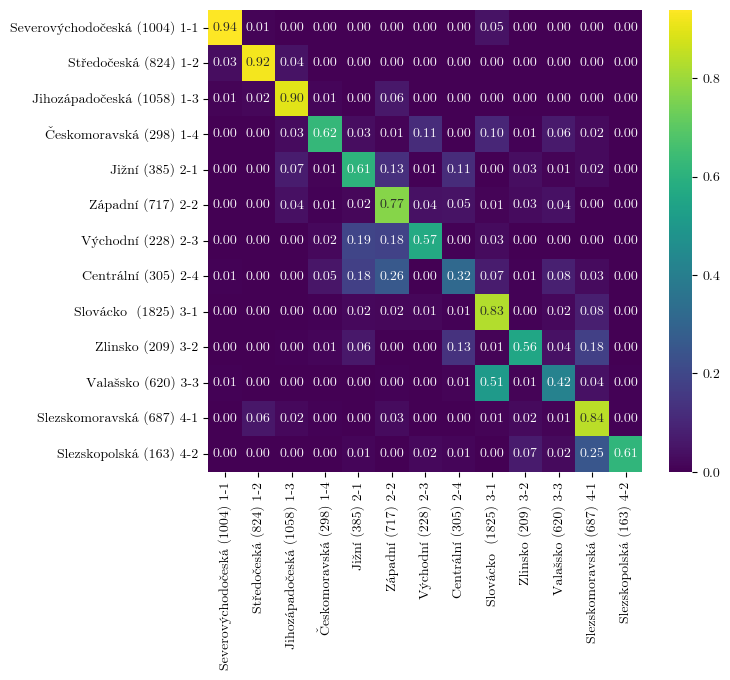

In [50]:
sm_data = softmax(data, axis=-1)  # Softmax data

cm = confusion_matrix(data, sid_int)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalized confusion matrix

xticklabels = [f"{subregions[u]} ({n}) {u}" for u, n in zip(unique, nunique)]
yticklabels = xticklabels

fig, ax = plt.subplots(1, figsize=(7, 6))
g = sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    cmap="viridis",
    annot_kws={"size": 10},
)

In [26]:
print(classification_report(sid_int, np.argmax(data, axis=-1), target_names=subregions.values(), output_dict=False))

                    precision    recall  f1-score   support

Severovýchodočeská       0.95      0.94      0.95      1004
       Středočeská       0.92      0.92      0.92       824
   Jihozápadočeská       0.89      0.90      0.89      1058
     Českomoravská       0.77      0.62      0.69       298
             Jižní       0.57      0.61      0.59       385
           Západní       0.66      0.77      0.71       717
          Východní       0.57      0.57      0.57       228
         Centrální       0.43      0.32      0.37       305
         Slovácko        0.78      0.83      0.80      1825
           Zlinsko       0.60      0.56      0.58       209
          Valašsko       0.66      0.42      0.51       620
   Slezskomoravská       0.68      0.84      0.75       687
     Slezskopolská       0.94      0.61      0.74       163

          accuracy                           0.77      8323
         macro avg       0.72      0.69      0.70      8323
      weighted avg       0.77      0.7

### Groups heatmap

In [12]:
# Calculate mean data for each region from the subregion softmaxed data
g_data = np.vstack(
    [
        np.mean(sm_data[:, 0:3], axis=-1),
        np.mean(sm_data[:, 3:7], axis=-1),
        np.mean(sm_data[:, 7:10], axis=-1),
        np.mean(sm_data[:, 10:12], axis=-1),
    ],
).transpose()


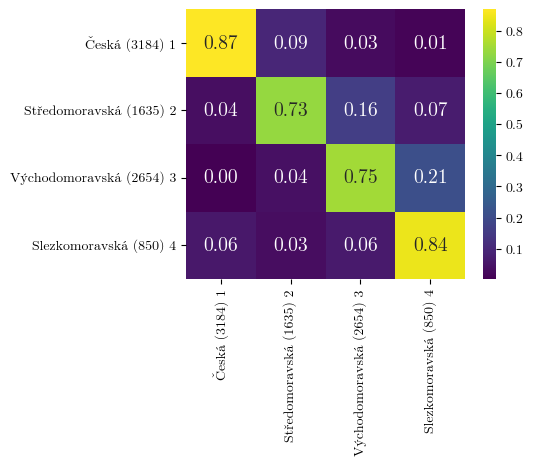

In [53]:
cm = confusion_matrix(g_data, gid_int)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalized confusion matrix

xticklabels = [f"{regions[u]} ({n}) {u}" for u, n in zip(g_unique, g_nunique)]
yticklabels = xticklabels

ax = plt.subplots(1, figsize=(4.5, 3.5))

g = sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    xticklabels=xticklabels,
    yticklabels=yticklabels,
    cmap="viridis",
    annot_kws={"size": 14},
)

In [27]:
print(classification_report(gid_int, np.argmax(g_data, axis=-1), target_names=regions.values()))

                 precision    recall  f1-score   support

          Česká       0.96      0.87      0.91      3184
 Středomoravská       0.74      0.73      0.73      1635
Východomoravská       0.83      0.75      0.79      2654
 Slezkomoravská       0.51      0.84      0.63       850

       accuracy                           0.80      8323
      macro avg       0.76      0.80      0.77      8323
   weighted avg       0.83      0.80      0.81      8323

